<a href="https://colab.research.google.com/github/atanasiusps/Machine-Learning-Enrichment_Task/blob/main/Chapter-15/Chapter_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CODE REPRODUCTION

Import Library

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Basic RNNs

Generate the Dataset

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


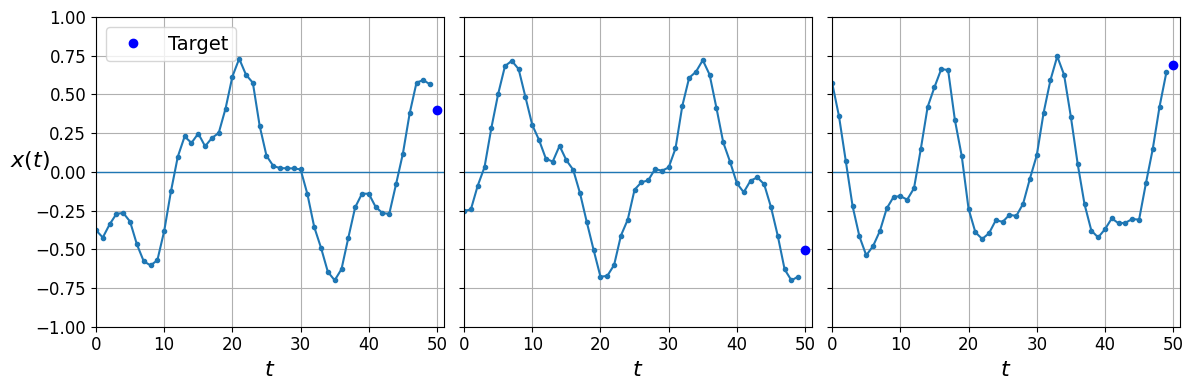

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

Computing Some Baselines

In [ ]:
from keras.losses import MeanSquaredError

mse = MeanSquaredError()
loss_value = mse(y_valid, y_pred).numpy()  # Convert Tensor to NumPy float
print(loss_value)

0.020211369


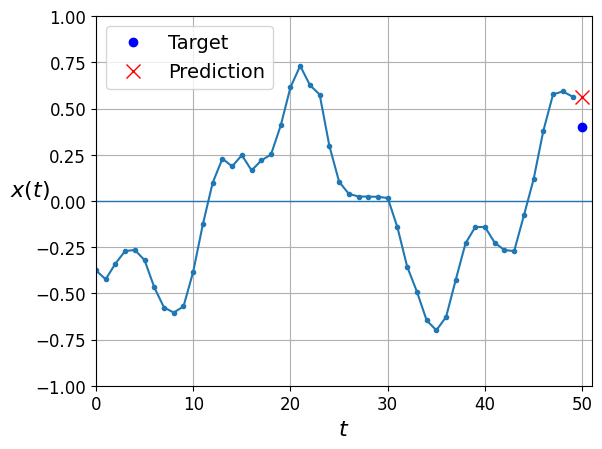

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1968 - val_loss: 0.0341
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0282 - val_loss: 0.0190
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0147
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038


0.003887552535161376

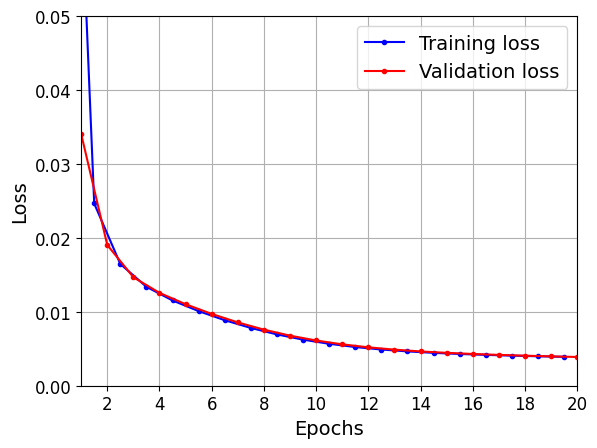

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


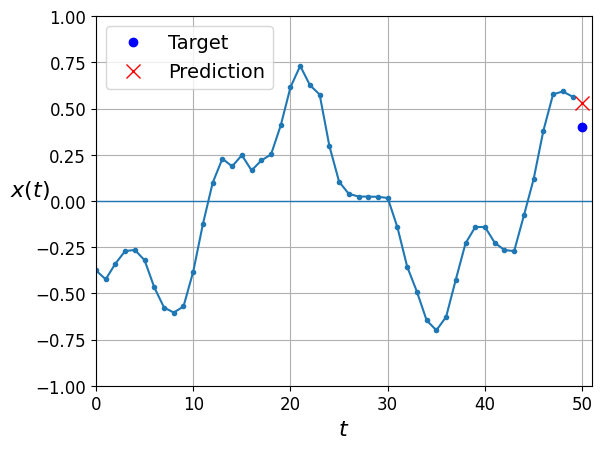

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()


Using a Simple RNN

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0815 - val_loss: 0.0192
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_loss: 0.0125
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0116
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110


0.010949001647531986

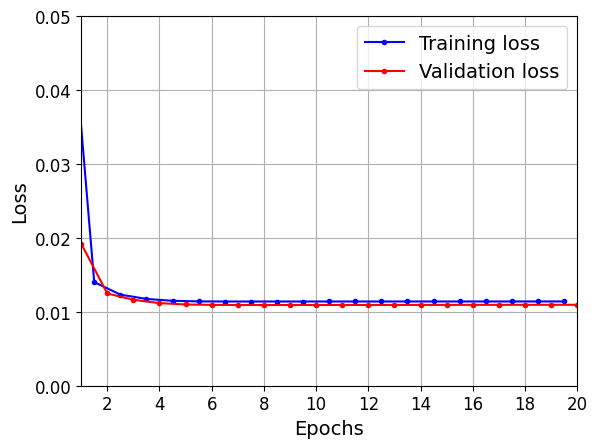

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


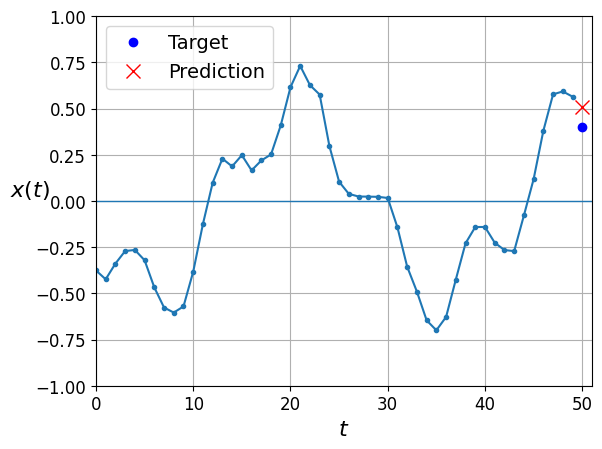

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Deep RNNs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.2118 - val_loss: 0.0117
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0104 - val_loss: 0.0065
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031


0.003238914767280221

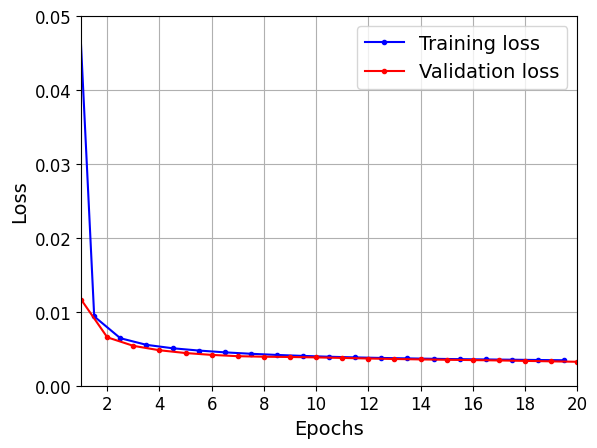

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


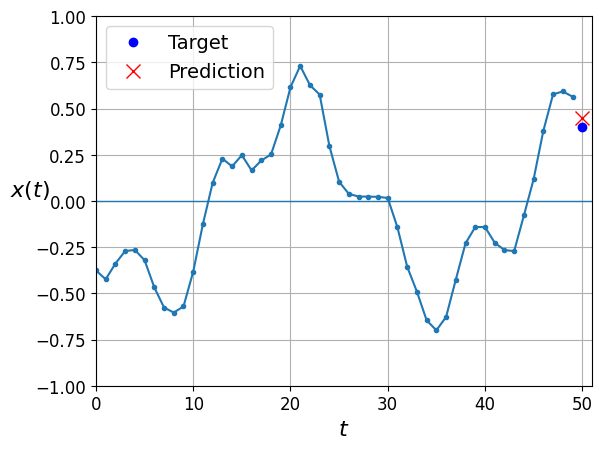

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.1096 - val_loss: 0.0060
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/st

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026


0.002755933441221714

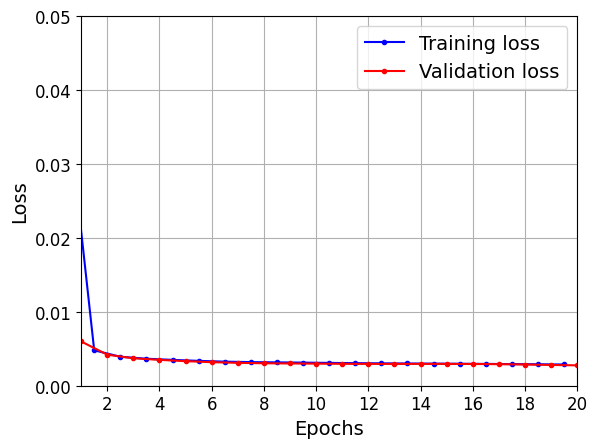

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


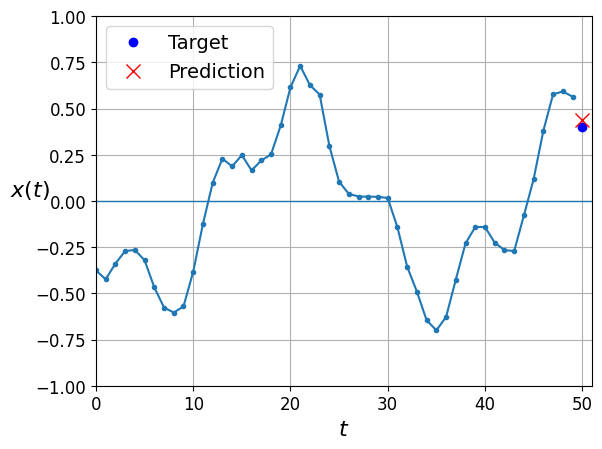

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Forecasting Several Steps Ahead

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


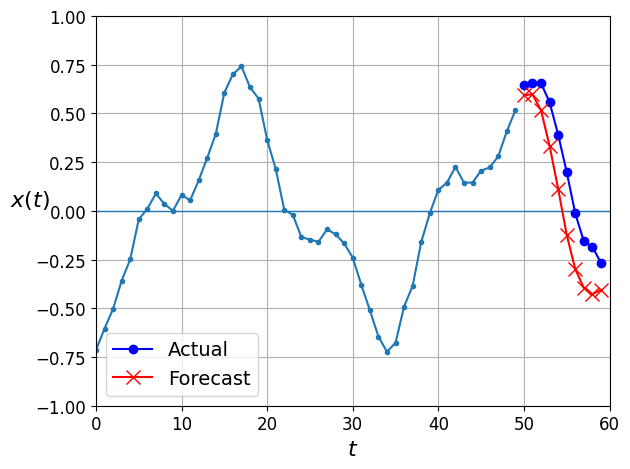

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
Y_pred.shape

(2000, 10)

In [ ]:
from keras.metrics import MeanSquaredError

mse = MeanSquaredError()
mse.update_state(Y_valid, Y_pred)
print(mse.result().numpy())


0.026762875


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_valid, Y_pred)
print(mse)


0.02676287852227688


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

Y_naive_pred = X_valid[:, -1, 0]  # shape: (samples,)
Y_naive_pred = np.repeat(Y_naive_pred[:, np.newaxis], Y_valid.shape[1], axis=1)  # shape: (samples, forecast_steps)

Y_valid_2d = Y_valid.reshape(Y_valid.shape[0], -1)
Y_naive_pred_2d = Y_naive_pred.reshape(Y_naive_pred.shape[0], -1)

mse = mean_squared_error(Y_valid_2d, Y_naive_pred_2d)
print("Naive MSE:", mse)


Naive MSE: 0.2569740414619446


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1845 - val_loss: 0.0657
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0582 - val_loss: 0.0455
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0428 - val_loss: 0.0372
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - val_loss: 0.0324
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0316 - val_loss: 0.0293
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0287 - val_loss: 0.0270
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0267 - val_loss: 0.0254
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0251 - val_loss: 0.0242
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0233
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0230 - val_loss: 0.0225
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0219
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


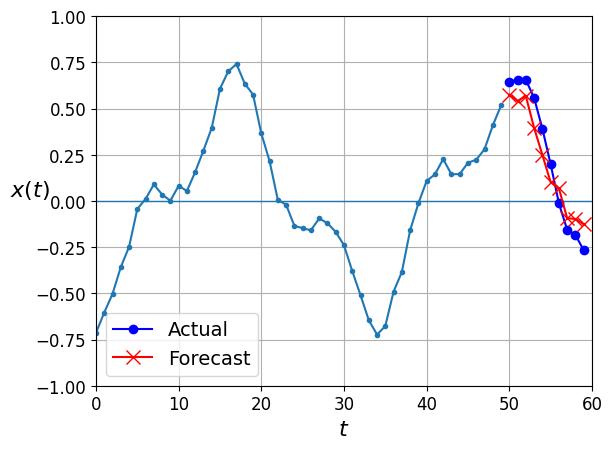

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return tf.reduce_mean(tf.square(Y_true[:, -1] - Y_pred[:, -1]))

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - last_time_step_mse: 0.0510 - loss: 0.0605 - val_last_time_step_mse: 0.0206 - val_loss: 0.0344
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - last_time_step_mse: 0.0219 - loss: 0.0347 - val_last_time_step_mse: 0.0185 - val_loss: 0.0305
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0175 - loss: 0.0299 - val_last_time_step_mse: 0.0159 - val_loss: 0.0285
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0134 - loss: 0.0264 - val_last_time_step_mse: 0.0111 - val_loss: 0.0237
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - last_time_step_mse: 0.0104 - loss: 0.0235 - val_last_time_step_mse: 0.0107 - val_loss: 0.0230
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0099 - loss: 0.0225 - val_last_time_step_mse: 0.0084 - val_loss: 0.0209
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0092 - loss: 0.0218 - val_last_time_step_mse

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


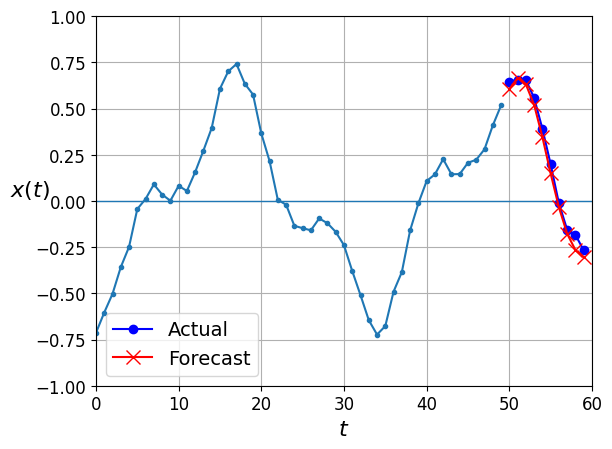

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Deep RNN with Batch Norm

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - last_time_step_mse: 0.3752 - loss: 0.3797 - val_last_time_step_mse: 0.0820 - val_loss: 0.0855
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - last_time_step_mse: 0.0535 - loss: 0.0632 - val_last_time_step_mse: 0.0464 - val_loss: 0.0556
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0430 - loss: 0.0524 - val_last_time_step_mse: 0.0388 - val_loss: 0.0492
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0381 - loss: 0.0474 - val_last_time_step_mse: 0.0353 - val_loss: 0.0456
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0345 - loss: 0.0439 - val_last_time_step_mse: 0.0312 - val_loss: 0.0422
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - last_time_step_mse: 0.0308 - loss: 0.0406 - val_last_time_step_mse: 0.0269 - val_loss: 0.0383
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - last_time_step_mse: 0.0266 - loss: 0.0374 - val_last_

Deep RNNs with Layer Norm

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if batch_size is None:
            batch_size = tf.shape(inputs)[0]
        if dtype is None:
            dtype = tf.float32  # Default dtype if none is provided
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - last_time_step_mse: 0.2218 - loss: 0.2423 - val_last_time_step_mse: 0.0491 - val_loss: 0.0633
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0479 - loss: 0.0605 - val_last_time_step_mse: 0.0401 - val_loss: 0.0543
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0403 - loss: 0.0529 - val_last_time_step_mse: 0.0331 - val_loss: 0.0480
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0331 - loss: 0.0466 - val_last_time_step_mse: 0.0263 - val_loss: 0.0419
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0268 - loss: 0.0415 - val_last_time_step_mse: 0.0222 - val_loss: 0.0379
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0232 - loss: 0.0379 - val_last_time_step_mse: 0.0201 - val_loss: 0.0352
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0210 - loss: 0.0355 - val_last_time_ste

Creating a Custom RNN Class

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.state_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer="glorot_uniform",
                                      name="kernel")
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer="orthogonal",
                                                name="recurrent_kernel")
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer="zeros",
                                    name="bias")
        self.ln = layers.LayerNormalization()
        super().build(input_shape)

    def call(self, inputs, states, training=None):
        prev_output = states[0]
        h = tf.matmul(inputs, self.kernel)
        h += tf.matmul(prev_output, self.recurrent_kernel)
        h += self.bias
        h = self.ln(h)
        output = self.activation(h)
        return output, [output]


In [ ]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def build(self, input_shape):
        if hasattr(self.cell, 'build'):
            self.cell.build(input_shape[-1:])
        super().build(input_shape)

    def get_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]

    def call(self, inputs, training=None, mask=None):
        def step_fn(input_at_t, states):
            return self.cell(input_at_t, states, training=training)

        time_major_inputs = tf.transpose(inputs, [1, 0, 2])
        initial_states = self.get_initial_state(inputs)

        last_output, outputs, final_states = keras.backend.rnn(
            step_function=step_fn,
            inputs=time_major_inputs,
            initial_states=initial_states
        )

        outputs = tf.transpose(outputs, [1, 0, 2])  # back to [batch, time, features]

        if self.return_sequences:
            return outputs
        else:
            return last_output


In [ ]:
# Create the model
model = keras.models.Sequential([
    keras.Input(shape=(None, 1)),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_rnn (MyRNN)                  │ (None, None, 20)       │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, None, 1)        │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501 (1.96 KB)

 Trainable params: 501 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

LSTMs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - last_time_step_mse: 0.0933 - loss: 0.1028 - val_last_time_step_mse: 0.0311 - val_loss: 0.0511
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0264 - loss: 0.0472 - val_last_time_step_mse: 0.0181 - val_loss: 0.0393
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - last_time_step_mse: 0.0163 - loss: 0.0372 - val_last_time_step_mse: 0.0144 - val_loss: 0.0335
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - last_time_step_mse: 0.0138 - loss: 0.0328 - val_last_time_step_mse: 0.0134 - val_loss: 0.0310
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - last_time_step_mse: 0.0130 - loss: 0.0307 - val_last_time_step_mse: 0.0129 - val_loss: 0.0295
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - last_time_step_mse: 0.0124 - loss: 0.0293 - val_last_time_step_mse: 0.0126 - val_loss: 0.0286
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0117 - loss: 0.0283 - val_las

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - last_time_step_mse: 0.0085 - loss: 0.0226


[0.02260003238916397, 0.008467206731438637]

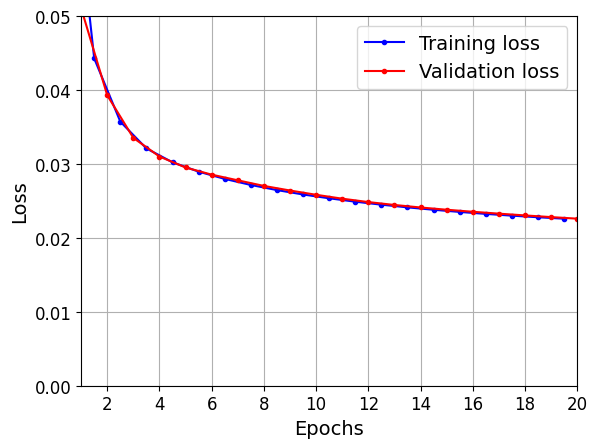

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


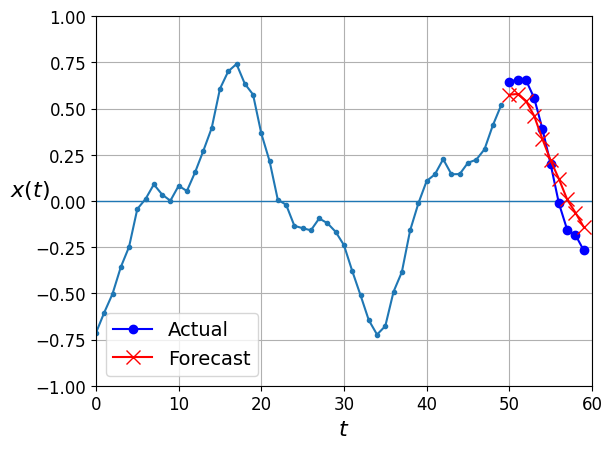

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

GRUs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - last_time_step_mse: 0.0933 - loss: 0.0990 - val_last_time_step_mse: 0.0413 - val_loss: 0.0520
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0404 - loss: 0.0500 - val_last_time_step_mse: 0.0357 - val_loss: 0.0461
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0355 - loss: 0.0452 - val_last_time_step_mse: 0.0298 - val_loss: 0.0409
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0295 - loss: 0.0395 - val_last_time_step_mse: 0.0223 - val_loss: 0.0334
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - last_time_step_mse: 0.0228 - loss: 0.0332 - val_last_time_step_mse: 0.0185 - val_loss: 0.0309
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0185 - loss: 0.0304 - val_last_time_step_mse: 0.0160 - val_loss: 0.0293
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - last_time_step_mse: 0.0155 - loss: 0.0287 - val_las

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - last_time_step_mse: 0.0069 - loss: 0.0207


[0.02082522213459015, 0.006779341958463192]

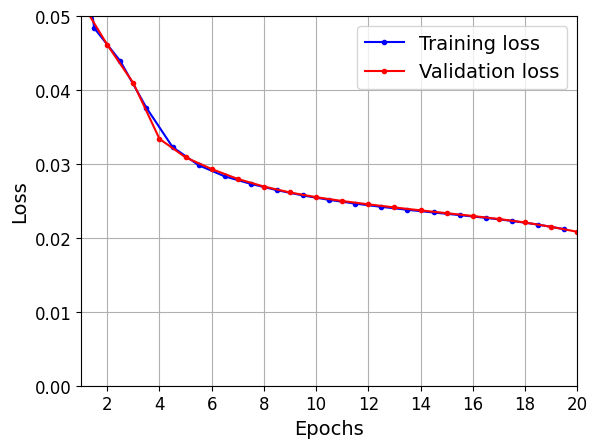

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:

np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


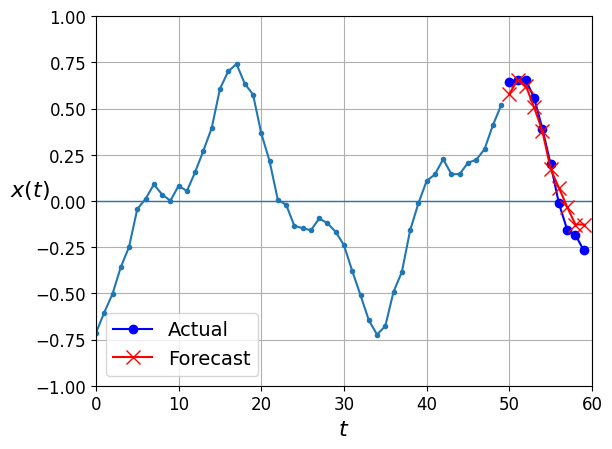

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Using One-Dimensional Convolutional Layers to Process Sequences

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - last_time_step_mse: 0.0837 - loss: 0.0897 - val_last_time_step_mse: 0.0362 - val_loss: 0.0449
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0344 - loss: 0.0418 - val_last_time_step_mse: 0.0235 - val_loss: 0.0335
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0225 - loss: 0.0316 - val_last_time_step_mse: 0.0161 - val_loss: 0.0274
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - last_time_step_mse: 0.0156 - loss: 0.0265 - val_last_time_step_mse: 0.0135 - val_loss: 0.0247
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - last_time_step_mse: 0.0132 - loss: 0.0245 - val_last_time_step_mse: 0.0121 - val_loss: 0.0234
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - last_time_step_mse: 0.0120 - loss: 0.0233 - val_last_time_step_mse: 0.0114 - val_loss: 0.0225
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0112 - loss: 0.0225 - val_last_time_step_


WaveNet

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - last_time_step_mse: 0.0943 - loss: 0.1016 - val_last_time_step_mse: 0.0234 - val_loss: 0.0372
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0222 - loss: 0.0354 - val_last_time_step_mse: 0.0181 - val_loss: 0.0313
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - last_time_step_mse: 0.0180 - loss: 0.0305 - val_last_time_step_mse: 0.0155 - val_loss: 0.0280
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0154 - loss: 0.0277 - val_last_time_step_mse: 0.0137 - val_loss: 0.0261
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - last_time_step_mse: 0.0138 - loss: 0.0260 - val_last_time_step_mse: 0.0126 - val_loss: 0.0248
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0128 - loss: 0.0249 - val_last_time_step_mse: 0.0120 - val_loss: 0.0241
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - last_time_step_mse: 0.0121 - loss: 0.0242 - val_last_time_step_mse:

In [ ]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 50, 1))
  warnings.warn(msg)


219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - last_time_step_mse: 0.1334 - loss: 0.1377 - val_last_time_step_mse: 0.1195 - val_loss: 0.1226
Epoch 2/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.1175 - loss: 0.1222 - val_last_time_step_mse: 0.1187 - val_loss: 0.1216


## EXECISES

**1. What are some applications of sequence to sequence, sequence to vector, and vector to sequence RNNs**

- Sequence to sequence RNNs digunakan dalam penerjemahan bahasa, transkripsi suara ke teks, dan sistem chatbot
- Sequence to vector RNNs digunakan untuk klasifikasi teks, deteksi sentimen, dan pengenalan suara
- Vector to sequence RNNs digunakan untuk menghasilkan teks dari masukan tetap seperti caption gambar atau sistem rekomendasi
<br><br>

**2. How many dimensions must the inputs of an RNN layer have and what does each dimension represent What about the outputs**

- Input RNN harus memiliki tiga dimensi yaitu batch size, timesteps, dan features
  - batch size adalah jumlah sampel dalam satu batch
  - timesteps adalah panjang urutan
  - features adalah jumlah fitur per langkah waktu
- Output juga tiga dimensi jika return sequences bernilai true, atau dua dimensi batch size dan units jika return sequences bernilai false
<br><br>

**3. If you want to build a deep sequence to sequence RNN which RNN layers should have return sequences set to true What about a sequence to vector RNN**

- Untuk sequence to sequence semua layer kecuali layer terakhir harus menggunakan return sequences true
- Untuk sequence to vector hanya layer terakhir menggunakan return sequences false sedangkan layer sebelumnya tetap true jika model bertingkat
<br><br>

**4. Suppose you have a daily univariate time series and you want to forecast the next seven days Which RNN architecture should you use**

- Gunakan arsitektur sequence to sequence RNN dengan pendekatan encoder decoder
- Encoder membaca data harian sebelumnya dan decoder menghasilkan tujuh nilai untuk tujuh hari yang akan datang
<br><br>

**5. What are the main difficulties when training RNNs and how can you handle them**

- Kesulitan utama meliputi
  - Vanishing gradients saat melatih urutan panjang
  - Overfitting pada data urutan pendek
  - Komputasi lambat karena ketergantungan waktu
- Cara mengatasinya
  - Gunakan LSTM atau GRU
  - Terapkan regularisasi seperti dropout dan early stopping
  - Gunakan teknik teacher forcing saat pelatihan
<br><br>

**6. Can you sketch the LSTM cell architecture**

- Arsitektur LSTM terdiri dari beberapa komponen
  - Forget gate untuk melupakan informasi lama
  - Input gate untuk menentukan informasi baru yang akan disimpan
  - Cell state sebagai memori jangka panjang
  - Output gate untuk menghasilkan keluaran berdasarkan memori saat ini
- Gate menggunakan fungsi aktivasi sigmoid dan cell menggunakan fungsi aktivasi tanh
<br><br>

**7. Why would you want to use one dimensional convolutional layers in an RNN**

- Conv satu dimensi dapat mengekstrak pola lokal dari urutan sebelum dikirim ke RNN
- Dapat mempercepat pelatihan dan menangkap pola pendek dengan efisien
- Sangat berguna dalam pemrosesan bahasa alami dan sinyal waktu
<br><br>

**8. Which neural network architecture could you use to classify videos**

- Untuk klasifikasi video dapat digunakan kombinasi CNN dan RNN
  - CNN mengekstrak fitur spasial dari setiap frame
  - RNN memproses urutan frame secara temporal
- Alternatif lain adalah menggunakan tiga dimensi CNN atau arsitektur transformer video seperti TimeSformer



9. Train a classification model for the SketchRNN dataset, available in TensorFlow
Datasets

In [ ]:
# Install TensorFlow Datasets if not already installed
!pip install -q tensorflow-datasets

# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load and take a small subset of MNIST (10 classes, 28x28 grayscale)
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',  # or 'fashion_mnist'
    split=['train[:1000]', 'test[:200]'],
    as_supervised=True,
    with_info=True
)

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = ds_train.map(preprocess).batch(32)
test_ds = ds_test.map(preprocess).batch(32)

print("MNIST subset loaded.")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.6J7ERU_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.6J7ERU_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
MNIST subset loaded.


In [ ]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

batch_size = 64

train_ds = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # change 5 if NUM_CLASSES is different
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,389 (876.52 KB)

 Trainable params: 224,389 (876.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 5  # You can increase if needed

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.1345 - loss: nan - val_accuracy: 0.0950 - val_loss: nan
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0988 - loss: nan - val_accuracy: 0.0950 - val_loss: nan
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1189 - loss: nan - val_accuracy: 0.0950 - val_loss: nan
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1093 - loss: nan - val_accuracy: 0.0950 - val_loss: nan
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1180 - loss: nan - val_accuracy: 0.0950 - val_loss: nan


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1005 - loss: nan 
Test Accuracy: 0.0950


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step 


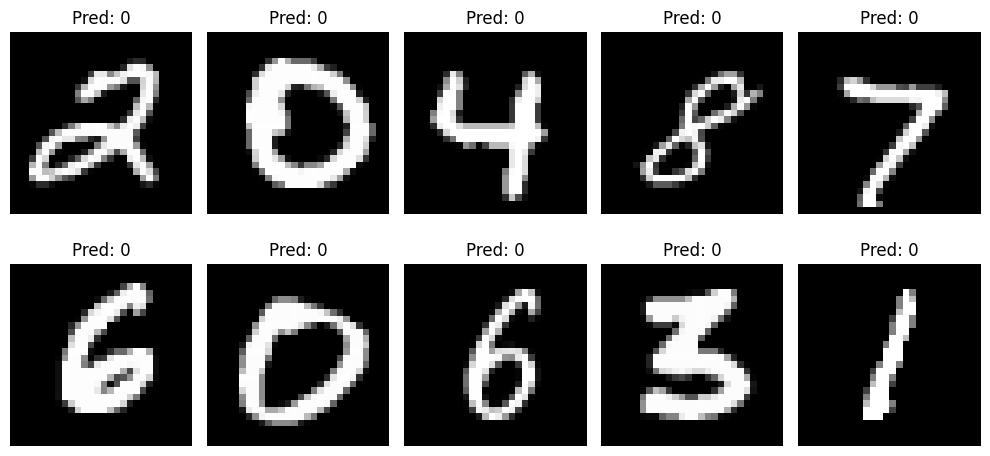

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        plt.title(f"Pred: {predicted_labels[i].numpy()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


10. Download the Bach chorales dataset and unzip it. It is composed of 382 chorales
composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long,
and each time step contains 4 integers, where each integer corresponds to a note’s
index on a piano (except for the value 0, which means that no note is played).
Train a model—recurrent, convolutional, or both—that can predict the next time
step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving
the model the start of a chorale and asking it to predict the next time step, then
appending these time steps to the input sequence and asking the model for the
next note, and so on. Also make sure to check out Google’s Coconet model,
which was used for a nice Google doodle about Bach.

In [ ]:
from tensorflow import keras

DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"

filepath = keras.utils.get_file(
    FILENAME,
    DOWNLOAD_ROOT + FILENAME,
    cache_subdir="datasets/jsb_chorales",
    extract=True
)


In [ ]:
from pathlib import Path

# Point to the extracted folder
jsb_chorales_dir = Path(filepath).parent / "jsb_chorales_extracted"

train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

print("Train files:", len(train_files))
print("Example file:", train_files[0])


Train files: 229
Example file: /root/.keras/datasets/jsb_chorales/jsb_chorales_extracted/train/chorale_000.csv


In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

print("Loaded:", len(train_chorales), "train chorales")
print("First chorale sample:", train_chorales[0][:2])  # First two timesteps


Loaded: 229 train chorales
First chorale sample: [[74, 70, 65, 58], [74, 70, 65, 58]]


In [ ]:
import numpy as np

n_notes = 89  # 88 piano keys + 0 for silence
seq_length = 32

def preprocess(chorales):
    X = []
    y = []
    for chorale in chorales:
        if len(chorale) < seq_length + 1:
            continue
        chorale = np.array(chorale)
        for i in range(len(chorale) - seq_length):
            X.append(chorale[i:i+seq_length])
            y.append(chorale[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = preprocess(train_chorales)
X_valid, y_valid = preprocess(valid_chorales)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (47900, 32, 4)
y_train shape: (47900, 4)


In [ ]:
import tensorflow as tf
from tensorflow import keras

embedding_dim = 32

model = keras.models.Sequential([
    keras.layers.Input(shape=(seq_length, 4)),
    keras.layers.Embedding(input_dim=n_notes, output_dim=embedding_dim),
    keras.layers.Reshape((seq_length, embedding_dim * 4)),
    keras.layers.LSTM(128),
    keras.layers.Dense(4 * n_notes, activation="softmax"),
    keras.layers.Reshape((4, n_notes))
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 32, 4, 32)      │         2,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 356)            │        45,924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 4, 89)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,356 (704.52 KB)

 Trainable params: 180,356 (704.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Reshape y: each note in the chord must be treated as a separate class
y_train_reshaped = np.expand_dims(y_train, axis=-1)
y_valid_reshaped = np.expand_dims(y_valid, axis=-1)

history = model.fit(
    X_train, y_train_reshaped,
    validation_data=(X_valid, y_valid_reshaped),
    epochs=10,
    batch_size=64
)


Epoch 1/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3797 - loss: 2.2483 - val_accuracy: 0.7380 - val_loss: 1.0782
Epoch 2/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7509 - loss: 1.0131 - val_accuracy: 0.7706 - val_loss: 0.9318
Epoch 3/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7685 - loss: 0.9120 - val_accuracy: 0.7776 - val_loss: 0.8851
Epoch 4/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7739 - loss: 0.8628 - val_accuracy: 0.7804 - val_loss: 0.8467
Epoch 5/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7773 - loss: 0.8149 - val_accuracy: 0.7825 - val_loss: 0.8200
Epoch 6/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7823 - loss: 0.7773 - val_accuracy: 0.7841 - val_loss: 0.7994
Epoch 7/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7868 - loss: 0.7462 - val_accuracy: 0.7853 - val_loss: 0.7833
Epoch 8/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7914 - loss: 0.7210 - val_accur

In [ ]:
X_test, y_test = preprocess(test_chorales)
y_test_reshaped = np.expand_dims(y_test, axis=-1)

test_loss, test_acc = model.evaluate(X_test, y_test_reshaped)
print("Test accuracy:", test_acc)


514/514 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7713 - loss: 0.8034
Test accuracy: 0.7749300599098206
